In [1]:
# Loading the required packages: 
import re
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization, Layer,SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow import  reshape, shape, transpose
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.preprocessing import LabelEncoder

from nltk.stem import PorterStemmer


import time 

In [2]:
# Load the dataset 
data = pd.read_csv("complaints.csv")
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605.0
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257.0
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225.0
3,2021-11-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,31707,NaN,NaN,Web,2021-11-01,In progress,Yes,NaN,4863965.0
4,2021-11-02,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Medical Data Systems, Inc.",VA,22033,NaN,NaN,Web,2021-11-02,In progress,Yes,NaN,4866449.0


In [3]:
data.dropna(subset=["Consumer complaint narrative"], inplace=True) 
#inplace = True changes the original dataset instead of defining a new one


In [4]:
product_map = {'Vehicle loan or lease': 'vehicle_loan',
               'Credit reporting, credit repair services, or other personal consumer reports': 'credit_report',
               'Credit card or prepaid card': 'card',
               'Money transfer, virtual currency, or money service': 'money_transfer',
               'virtual currency': 'money_transfer',
               'Mortgage': 'mortgage',
               'Payday loan, title loan, or personal loan': 'loan',
               'Debt collection': 'debt_collection',
               'Checking or savings account': 'savings_account',
               'Credit card': 'card',
               'Bank account or service': 'savings_account',
               'Credit reporting': 'credit_report',
               'Prepaid card': 'card',
               'Payday loan': 'loan',
               'Other financial service': 'others',
               'Virtual currency': 'money_transfer',
               'Student loan': 'loan',
               'Consumer Loan': 'loan',
               'Money transfers': 'money_transfer'}
data.replace({"Product": product_map}, inplace=True)
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1,2019-11-01,vehicle_loan,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257.0
7,2019-07-08,credit_report,Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Hello This complaint is against the three cred...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,109XX,NaN,Consent provided,Web,2019-07-08,Closed with explanation,Yes,NaN,3299394.0
8,2020-06-10,credit_report,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MT,NaN,Servicemember,Consent provided,Web,2020-06-10,Closed with explanation,Yes,NaN,3692762.0
10,2019-07-03,credit_report,Credit reporting,Incorrect information on your report,Account information incorrect,Two accounts are still on my credit history af...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,328XX,NaN,Consent provided,Web,2019-07-03,Closed with non-monetary relief,Yes,NaN,3294745.0
13,2019-03-21,credit_report,Other personal consumer report,Identity theft protection or other monitoring ...,Received unwanted marketing or advertising,Receiving daily telephone call ( s ) from XXXX...,Company has responded to the consumer and the ...,"NRA Group, LLC",MA,NaN,NaN,Consent provided,Web,2019-03-27,Closed with explanation,Yes,NaN,3186954.0


In [8]:
# Check the frequency of each labeled product
frequency = data['Product'].value_counts()
print(frequency)
frequency = pd.DataFrame(label_encoder.inverse_transform(labels)).value_counts()

Product
credit_report      83297
debt_collection    28216
card               15499
mortgage           12333
savings_account     9648
loan                5970
money_transfer      4436
vehicle_loan        3578
others                 8
Name: count, dtype: int64


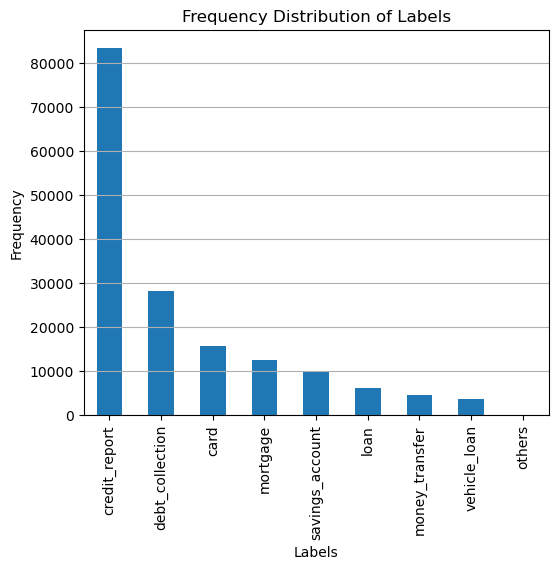

In [6]:
# Plot the distribution of the labels 
# Plot the frequency distribution
frequency.plot(kind='bar', figsize=(6, 5))
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Labels')
plt.xticks(range(9))  # Ensuring all labels from 0 to 8 are shown
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

So our goal becomes to choose a stratified sample from the dataset before defining the independent x and dependent y. Note that if we pick the training dataset such that it also follows the population distribution, then the model is biased towards 1 and predicts many samples to be under that category. So to avoid this, we will pick an equal number of samples from each category; except for category 6 for which we only have 8 samples.  
how to do? 
there must be a grouping based on the labels. we want the same number of categories in our training set so that the data is balanced. 

In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(data["Product"]) #looks through the column 'Product' and assigns a factor to each category. 

labels = label_encoder.transform(data["Product"]) #replace the categories with their corresponding integers assigned. 
print(labels.shape)
labels

(162985,)


array([8, 1, 1, ..., 1, 2, 8])

In [9]:
x = data['Consumer complaint narrative']
print(x.head())
print(f"\nNumber of samples: {len(x)}")
type(x)

1     I contacted Ally on Friday XX/XX/XXXX after fa...
7     Hello This complaint is against the three cred...
8     I am a victim of Identity Theft & currently ha...
10    Two accounts are still on my credit history af...
13    Receiving daily telephone call ( s ) from XXXX...
Name: Consumer complaint narrative, dtype: object

Number of samples: 162985


pandas.core.series.Series

In [10]:
# Convert the input to a list: 
x = list(x)
x[0]

'I contacted Ally on Friday XX/XX/XXXX after falling behind on payments due to being out of work for a short period of time due to an illness. I chated with a representative after logging into my account regarding my opitions to ensure I protect my credit and bring my account current. \n\nShe advised me that before an extenstion could be done, I had to make a payment in the amount of {$270.00}. I reviewed my finances, as I am playing catch up on all my bills and made this payment on Monday XX/XX/XXXX. This rep advised me, once this payment posts to my account to contact Ally back for an extention or to have a payment deffered to the end of my loan. \n\nWith this in mind, I contacted Ally again today and chatted with XXXX. I explained all of the above and the information I was provided when I chatted with the rep last week. She asked several questions and advised me that a one or two month  extension/deffered payment could be done however partial payment is needed! WHAT? She advised me 

In [16]:
def edit_text(x): 
    """
    Input 
    
    X       : The input sentences into the model. Note that X must be in the format of a list. 
    m       : The fixed length of the sequences. 

    Output
    
    Tokens : This is a list of dictionaries. Each dictionary corresponds to a sampel sequence. 
             The dictionary contains a vector of integers correponding to the words in the sequence 
             and an attention mask. 
    """

    # Convert the text into lower case: 
    input_text = [i.lower() for i in x]
    
    # Remove the punctuations: 
    input_text = [re.sub(r"[^\w\d'\s]+", " ", i) for i in input_text]
    
    # Remove digits from the text: 
    input_text = [re.sub("\d+", "", i) for i in input_text]
    
    # Remove more than one instance of 'x': 
    input_text = [re.sub(r'[x]{2,}', "", i) for i in input_text]
    
    # Once digits are removed, there will be double spaces between the words. Remove them: 
    input_text = [re.sub(' +', ' ', i) for i in input_text]
    
    #Tokenize the comments: 
    input_text = [word_tokenize(x) for x in tqdm(input_text)]

    # Remove the stop words; significantly reduces the length of each complaint: 
    stop_word_list = set(stopwords.words('english'))
    input_text = [[word for word in review if word not in stop_word_list] for review in input_text]

    # Reduce words to their stem words 
    stemmer = PorterStemmer()
    input_text = [[stemmer.stem(word) for word in review]for review in input_text]

    # Rejoin the strings: 
    input_text = [' '.join(review) for review in input_text]
    
    return(input_text)

In [17]:
x = edit_text(x)
x[0]

100%|█████████████████████████████████| 162985/162985 [00:32<00:00, 4983.12it/s]


'contact alli friday fall behind payment due work short period time due ill chate repres log account regard opit ensur protect credit bring account current advis extenst could done make payment amount review financ play catch bill made payment monday rep advis payment post account contact alli back extent payment deffer end loan mind contact alli today chat explain inform provid chat rep last week ask sever question advis one two month extens deffer payment could done howev partial payment need advis about would due within day accept agreement remain bal about would due payment per month would resum case offer made payment could catch bill compani work new jersey sinc close like due illeg practic chang loan compani compani sign paperwork anoth kill interest rate never consid refianc vechil lower interest rate due age vechil compani take work'

In [18]:
# Define a dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
vocab_size

39772

Without the stemmer the number of words in the vocabulary is 57797. While using stem words we have 39772 words in the dictionary. 

In [19]:
#dividing the dataset into 75% training set and 25% test set: 
X_train, X_test, y_train, y_test = train_test_split(x,labels, 
                                   random_state=104,  
                                   test_size=0.25,  
                                   shuffle=True,
                                   stratify=labels) 


In [20]:
# Let's compare the frequency of labels in the training and testing sets
frequency_training = pd.DataFrame(label_encoder.inverse_transform(y_train)).value_counts()
frequency_testing = pd.DataFrame(label_encoder.inverse_transform(y_test)).value_counts()


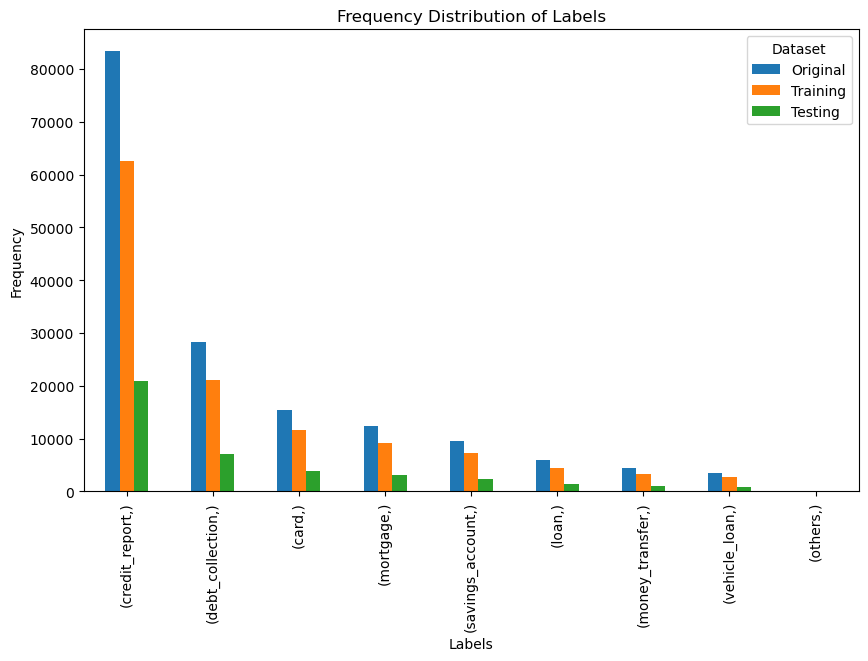

In [21]:
freq_df = pd.DataFrame({
    'Original': frequency,
    'Training': frequency_training,
    'Testing': frequency_testing
})
freq_df.plot(kind='bar', figsize=(10, 6))
plt.title('Frequency Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Optional: Adjust x-axis label rotation
plt.legend(title='Dataset')
plt.xticks(rotation = 90)
plt.show()

In [22]:
X_train[0]

"shock review credit report found late payment date day late sure happen believ made payment receiv statement happen person went bank spoke relationship manag name area told bank made error automat payment form fix doubl payment made also 'm sure n't even catch prior thought monthli statement get contest employe intern bank error"

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


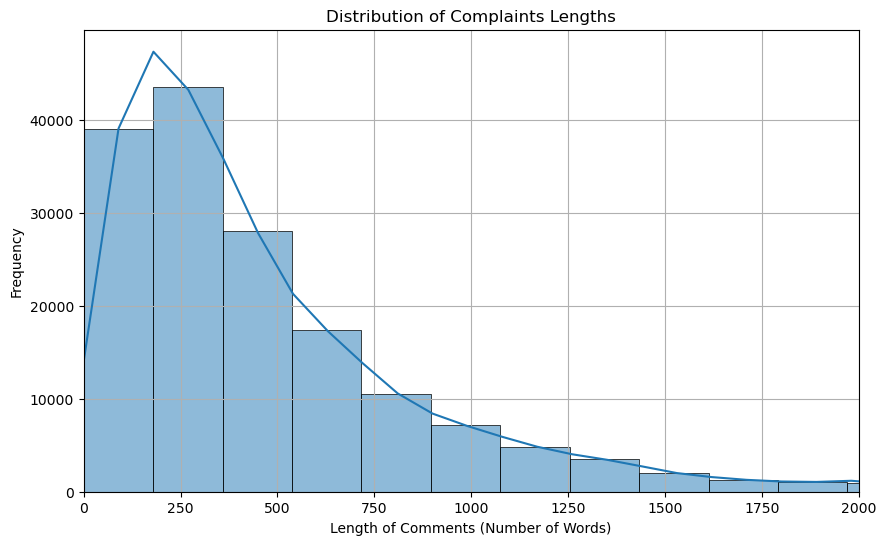

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
lengths = [len(comment) for comment in x]

# Plot the distribution of length 
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=100, kde=True)  # kde=True adds a kernel density estimate
plt.title('Distribution of Complaints Lengths')
plt.xlabel('Length of Comments (Number of Words)')
plt.ylabel('Frequency')
plt.xlim(0, 2000)
plt.grid(True)
plt.show()

In [24]:
tokenizer.fit_on_texts(X_train)
# Convert texts to sequences of integers
X_train_tokenized = tokenizer.texts_to_sequences(X_train)


In [25]:
X_train_tokenized[0][-10:]

[367, 551, 277, 93, 28, 1599, 517, 865, 13, 188]

In [26]:
X_train_tokenized = pad_sequences(X_train_tokenized, maxlen=200, padding='post')
X_train_tokenized[210]

array([ 154,   15,  203,    1,   97,   89,  544,   73,    8,    3,    3,
        437,  229,  250,  688,  103,    8, 2588,    8,   62,  108,   95,
          2,   47,    3,  108,  149,  470,   77,    4,  109,  292,  123,
         49,   99,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [27]:
tokenizer.fit_on_texts(X_test)
# Convert texts to sequences of integers
X_test_tokenized= tokenizer.texts_to_sequences(X_test)
# Add the paddings 
X_test_tokenized = pad_sequences(X_test_tokenized, maxlen=200, padding='post')
X_test_tokenized[0]

array([  7, 165, 105,   2,   3, 403, 878, 368,  66, 522,  95,   3,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [28]:
X_test_tokenized.shape

(40747, 200)

This tokenization occurs based on the frequency of the words (bag of words) 

In [29]:
# Example of the Embedding layer: 
embedding_dim = 50  # Dimensionality of the embedding vector

embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=200)
X_trainmod = embedding_layer(X_train_tokenized)
X_testmod = embedding_layer(X_test_tokenized)
X_trainmod.shape

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


TensorShape([122238, 200, 50])

In [17]:
X_trainmod[0][0] #first sample first word 

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.01532959,  0.01855406, -0.02964407, -0.04449312,  0.04442677,
        0.04172537,  0.03704533, -0.00019524,  0.04475288, -0.04934553,
       -0.04141152, -0.01694614, -0.0434658 , -0.03270526,  0.011671  ,
       -0.04854363, -0.02200906,  0.0401073 ,  0.02891589, -0.03398073,
        0.02791942, -0.03443774,  0.04231251, -0.00308875,  0.01601509,
       -0.01544087, -0.00380721, -0.00526493, -0.01844056, -0.03153126,
        0.03933065, -0.03657141,  0.00318868,  0.00161099,  0.04278022,
        0.0284874 , -0.03851178,  0.03986325,  0.00304899, -0.03177607,
        0.0172457 ,  0.0140498 ,  0.01506401,  0.02259262,  0.00681389,
       -0.03341268, -0.0057282 , -0.03384151,  0.02252359, -0.02390413],
      dtype=float32)>

### Add padding 

In [30]:
def create_padding_mask(matrix,num_heads):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
    # Check what indexes are 0
    zero_rows = tf.cast(tf.equal(matrix, 0), dtype=tf.float32)
    padded_matrix_1 = tf.repeat(tf.expand_dims(zero_rows, axis=1), repeats=num_heads, axis=1)
    padded_matrix = tf.cast(tf.expand_dims(padded_matrix_1, axis=-2),dtype=tf.float32)

    return padded_matrix

In [55]:
padding_mask = create_padding_mask(X_train_tokenized,2)
padding_mask.shape

TensorShape([122238, 2, 1, 200])

In [23]:
padding_mask[0]

<tf.Tensor: shape=(2, 1, 100), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 1.]]], dtype=float32)>

### Add Positional Encodings 

In [31]:
# Calculate the angles for positional embeddings: 

def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # Get i from dimension span k
    i = k//2
    # Calculate the angles using pos, i and d
    angles = pos/ (10000)**(2*i/d)

    
    return angles
    
def pos_emb(len_seq,len_emb): 
    
    """
    This function creates the positional embeddings for all the words in the sequence based on: 
    
    Input: 
    len_seq (int) : The length of the sequences inputed into the model. 
    len_emb (int) : The length of the word embeddings for every word in the sequence. 

    Note: the size of the positional encoding and the word embeddings must match in order to add them in the next step. 

    Output: 
    res (np.array(len_seq, len_emb)) : ith row of this matrix represents the positional encodings for the ith position in the sequence. 

    """

    len_i = int(len_emb/2)

    # Initialize the matrix to save positional encodings: 
    res = np.zeros((len_seq,len_emb))
    angles = np.zeros((len_seq,len_emb))
    
    #for each position in the sequence 
    for pos in range(len_seq): 
        
        #calculate the angles: 
        for i in range(len_i): 
            angles[pos,2*i] = pos/(10000**(2*i/len_emb))
            angles[pos, 2*i +1] = pos/(10000**(2*i/len_emb)) 
        
        # Calculate the entries corresponding to each position 
        #for j in range(len_i): 
        res[pos, 0::2] = np.sin(angles[pos,0::2])
        res[pos,1::2] = np.cos(angles[pos,0::2])
            
    return(tf.cast(res.reshape(1,len_seq,len_emb), dtype=tf.float32))


In [20]:
# Create the positional embeddings: 
position_enc = pos_emb(X_trainmod.shape[1],X_trainmod.shape[2])
position_enc.shape

TensorShape([1, 200, 50])

In [105]:
X_trainmod = X_trainmod + position_enc
X_testmod = X_testmod + position_enc

In [32]:
def self_attention(q,k,v,masking):
    """
    
    """
  
    # Perform matrix multiplication on the last two dimensions
    dotqk = tf.matmul(q, k, transpose_b = True)

    #dim_k = tf.cast(k.shape[-1],tf.float32)
    dim_k = tf.cast(80, tf.float32)
    normalized_dotqk = dotqk/tf.math.sqrt(dim_k)
    
    # Add the masking if masking is given 
    if masking is not None: 
        normalized_dotqk += ((masking)* (-1e9))
    
    attention_scores =  tf.nn.softmax(tf.cast(normalized_dotqk, dtype=tf.float32),axis = -1)
    res = tf.matmul(attention_scores,v) 
    
    return(res)
    

In [33]:
def FullFeedForward(n_1, emb_size):#the model must return vectors of the same size as the embeddings of the input so can be combined with decoder
    model = Sequential([
    Dense(n_1, activation='tanh', name="dense1"), #relu? (#samples, len_seq, n_1)
    Dense(emb_size, activation='tanh', name="dense2")# linear? (#samples, len_seq, emb_size)
])
    return(model)
    

In [34]:
# Define a reshape_tensor which will be later on used for the Multi-head attention: 

def reshape_tensor(q_matrix, heads, pre_attention): 
    """
    """
    
    #pre_attention, we'll need to reform into 4d 
    if pre_attention:

        dense_qre = reshape(q_matrix, (shape(q_matrix)[0], shape(q_matrix)[1], heads, -1))
        dense_qre = transpose(dense_qre, ([0, 2, 1, 3])) #(#samples, num_heads,len_seq, dim_q/num_heads)
        
        
    #post_attention, we'll need to revert back to 3d: 
    else: 
        q_matrix_transpose = transpose(q_matrix, ([0,2,1,3]))
        dense_qre = reshape(q_matrix_transpose, (shape(q_matrix_transpose)[0], shape(q_matrix_transpose)[1], -1)) 
        
        
    return(dense_qre)
        

In [35]:
class MultiHeadAttention(Layer): 

    def __init__(self, dim_kv, dim_q, heads, **kwargs):
        
        super(MultiHeadAttention, self).__init__(**kwargs) 
        self.heads = heads
        self.denseq = Dense(units = dim_q)
        self.densek = Dense(units = dim_kv)
        self.densev = Dense(units = dim_kv) 
        
    
    def call(self,q,k,v,masking, **kwargs): #by passing self, you passed all the attributes you've defined above. 
       
        # Define the query, key, and value matrices: 
        dense_q = tf.cast(self.denseq(q), dtype=tf.float32) # shape = (#samples, len_seq, dim_q)
        dense_k = tf.cast(self.densek(k),dtype = tf.float32) # shape = (#samples, len_seq, dim_k) 
        dense_v = tf.cast(self.densev(v), dtype = tf.float32) # shape = (#samples, len_seq, dim_v) 
        
        # Reshape: 
        dense_qre = reshape_tensor(dense_q, self.heads, pre_attention = True) #shape = (#samples, #heads, dim_q/heads, len_seq)
        dense_kre = reshape_tensor(dense_k, self.heads, pre_attention = True) #shape = (#samples, #heads, dim_k/heads, len_seq)
        dense_vre = reshape_tensor(dense_v, self.heads, pre_attention = True) #shape = (#samples, #heads, dim_v/heads, len_seq) 

        
        # Calculate the attention scores: 
        attention_scores = self_attention(dense_qre, dense_kre,dense_vre,masking) #shape = (#samples, #heads, dim_q/heads, len_seq)
        
        # Revert the shape:
        attention_with_v = reshape_tensor(attention_scores, self.heads, pre_attention = False) #shape = (#samples, len_seq, dim_q)
        
        return(attention_with_v)


In [27]:
# Check if it works: 
dim_kv = 40
dim_q = 40
heads = 4
masking = create_padding_mask(X_train_tokenized[0:10],heads)
function = MultiHeadAttention(dim_kv, dim_q, heads)

#start timing 
start_time = time.time()
print(function(X_trainmod[0:10], X_trainmod[0:10], X_trainmod[0:10],masking).shape)
end_time = time.time() 
print(f"mha with the padding mask took {(end_time-start_time)} seconds")
#once the padding mask is added it's taking longer to calculate the mha. 

(10, 200, 40)
mha with the padding mask took 0.06645607948303223 seconds


In [36]:
class Encoder(Layer):
    
    def __init__(self, dim_kv, dim_q, heads, fnn_neurons, len_emb, iter, len_rank, vocab_size, drop_rate):
        super(Encoder,self).__init__()
        
        self.heads        = heads
        self.len_emb      = len_emb
        self.iter         = iter
        
        
        self.norm1        = LayerNormalization(epsilon = 1e-6)
        self.norm2        = LayerNormalization(epsilon = 1e-6)
        self.norm3        = LayerNormalization(epsilon = 1e-6)
        
        self.drop1        = Dropout(rate = drop_rate)
        self.drop2        = Dropout(rate = drop_rate)
        self.drop3        = Dropout(rate = drop_rate)
        self.drop4        = Dropout(rate = drop_rate)
        self.drop5        = Dropout(rate = drop_rate)
        
        self.emb_layer    = Embedding(input_dim=vocab_size, output_dim=len_emb, input_length=200)
        self.fnn          = FullFeedForward(fnn_neurons, len_emb)
        self.mha          = MultiHeadAttention(dim_kv, dim_q, heads)
        self.dense1       = Dense(units = 1)
        self.dense2       = Dense(units = len_rank, activation = 'softmax')
        self.dense3       = Dense(units = len_emb)
       
        

    def call(self,x,masking,training): 
        
        """
       Task:  Classification of the customer complaints
       
       Compartments: 
          - Defining the padding_mask if necessary 
          - Embedding layer 
          - Positional encoding layer 
          - Encoder loop -> Multi-Head Attention + Feed Forward neural network 
          - Dense layer 1 with activation function 'linear' 
          - Dense layer 2 with activation function 'softmax'
        
       Input 
       x        : The tokenized customer complaints that are converted into integer vectors. Expected shape = (#samples, len_seq) 
       masking  : Boolean value if True, padding mask will be applied. 
       training : Boolean value if True, Dropout layers are active. 

       Output 
       probs    : Output probabilities shape = (#samples, #num_categories) 
       
       """
        
        # Define the masking if True
        if masking == True: 
            padding_mask = create_padding_mask(x,self.heads)
            
        # Add the embedding layer 
        x = self.emb_layer(x)
        len_seq = x.shape[1]
        
        # Add positional encodings: 
        x += pos_emb(len_seq, self.len_emb)

        for _ in range(self.iter): 
            # Add dropout layer:
            drop_x = self.drop1(x, training = training)
            # Calculate the attention scores: 
            mha_scores = self.mha(drop_x, drop_x, drop_x,padding_mask)

            # Add dropout and normalize: 
            dropout_1 = self.drop2(mha_scores, training = training)
            norm_1  = self.norm1(dropout_1 + x )
            
            #Run through a fully connected neural network: 
            fnn_output = self.fnn(norm_1) 
              
            # Add dropout:
            dropout_2 = self.drop3(fnn_output, training = training)
               
            # Normalize: 
            x = self.norm2(dropout_2 + norm_1)

        # Run through a dense layer to combine all the word embeddings of each word: 
        x = self.drop5(self.dense3(x))
        x = self.dense1(x)
        x = tf.squeeze(x, axis=-1)
        x = self.norm3(self.drop4(x, training = training))
        
        # Run through a dense layer activation function = 'softmax': 
        probs = self.dense2(x)
        
        return probs


In [38]:
dim_kv = 60 
dim_q = 60
len_emb = 60
heads = 6
fnn_neurons = 40
drop_rate = 0.4
len_rank = 9
iter = 3 #based on the paper  
encoder = Encoder(dim_kv, dim_q, heads, fnn_neurons, len_emb, iter, len_rank,vocab_size, drop_rate)
output_encoder = encoder(X_train_tokenized[0:100],masking = True, training = True)# we need the padding mask before training. 
output_encoder.shape

TensorShape([100, 9])

In [193]:
print(output_encoder[0])
print(tf.argmax(output_encoder[0]))

tf.Tensor(
[0.07411161 0.07419901 0.16975555 0.11949079 0.10802262 0.04904662
 0.0156932  0.0086809  0.3809997 ], shape=(9,), dtype=float32)
tf.Tensor(8, shape=(), dtype=int64)


In [39]:
inputs = tf.keras.Input(shape=(200,))
outputs = encoder(inputs, masking = True, training=True)  # Assuming training=True for now
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Encoder)               │ (None, 9)              │     2,408,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,408,370 (9.19 MB)

 Trainable params: 2,408,370 (9.19 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tensorflow.keras.optimizers import Adam
opt = Adam(0.002,beta_1 = 0.9, beta_2 = 0.999, decay = 0.01) 
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [41]:
def output_vec(y,num_cat): 
    """
    This function takes the label and creates a vector of zeros except 
    the index corresponding to the label. 
    
    Inputs 
    y : this is a list of labels 
    num_cat : number of categories 
    
    """
    leny = len(y)
    output_vec = np.zeros((leny,num_cat))
    
    for i in range(leny): 
        index = y[i] # say this is 5  
        output_vec[i,index] = 1
    return(output_vec)
        

In [42]:
y_trainmod = output_vec(y_train, 9)
y_testmod = output_vec(y_test,9) 
print(y_trainmod[0])
print(y_train[0])
print(y_trainmod.shape)

[1. 0. 0. 0. 0. 0. 0. 0. 0.]
0


In [ ]:
import time

# Start time
start_time = time.time()

model.fit(X_train_tokenized,y_trainmod, epochs=5, batch_size=800,  validation_split=0.2)

# End time
end_time = time.time()
print(f"process time: { (end_time-start_time)/60}")

In [47]:
# Print some of the predictions: 
predictions = model.predict(X_train_tokenized[0:10])
for i in range(10): 
    argmax_pred = tf.argmax(predictions[i])
    print(f"category predicted = {label_encoder.inverse_transform([argmax_pred])}")
    print(f"the correct category is {label_encoder.inverse_transform([y_train[i]])}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
category predicted = ['card']
the correct category is ['card']

category predicted = ['credit_report']
the correct category is ['credit_report']

category predicted = ['card']
the correct category is ['card']

category predicted = ['credit_report']
the correct category is ['credit_report']

category predicted = ['credit_report']
the correct category is ['credit_report']

category predicted = ['credit_report']
the correct category is ['credit_report']

category predicted = ['debt_collection']
the correct category is ['debt_collection']

category predicted = ['credit_report']
the correct category is ['credit_report']

category predicted = ['vehicle_loan']
the correct category is ['vehicle_loan']

category predicted = ['credit_report']
the correct category is ['credit_report']



In [48]:
# Evaluate the model on the testing set: 
model.evaluate(X_test_tokenized, y_testmod)

1274/1274 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - accuracy: 0.6652 - loss: 1.3582


[1.3558675050735474, 0.6682700514793396]

Note that accuracy would not be the most appropriate metric to measure the performance of the model specially when the dataset is unbalanced. The model can predict the majority of samples to belong to class 1 and it can show that it has high accuracy while in fact the model under-preforms when predicting the under-represented categories in the dataset. 

In [46]:
y_pred = model.predict(X_test_tokenized)
y_pred.shape

1274/1274 ━━━━━━━━━━━━━━━━━━━━ 57s 45ms/step


(40747, 9)

In [47]:
arg_max_predictions = np.zeros(y_pred.shape[0], dtype=int)
for i in range(y_pred.shape[0]): 
    arg_max_predictions[i] = np.argmax(y_pred[i])
    
arg_max_predictions.shape   

(40747,)

In [114]:
arg_max_predictions[0:10]

array([1, 7, 1, 2, 0, 0, 1, 2, 5, 5])

In [115]:
y_test[0:10]

array([1, 7, 1, 2, 7, 4, 1, 1, 8, 1])

In [119]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
# Step 4: Calculate metrics
precision = precision_score(y_test, arg_max_predictions,average='weighted')
recall = recall_score(y_test, arg_max_predictions,average='weighted')
print(f"precision of the model: {precision}") # focuses on false positives 
print(f"recall of the model: {recall}")# focuses on false negatives 

precision of the model: 0.6275036651309561
recall of the model: 0.641028787395391


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
# y_test: true labels, y_pred: predicted labels
print(classification_report(y_test, arg_max_predictions))

              precision    recall  f1-score   support

           0       0.48      0.53      0.50      3875
           1       0.74      0.83      0.78     20825
           2       0.60      0.47      0.53      7054
           3       0.51      0.32      0.40      1493
           4       0.32      0.10      0.15      1109
           5       0.48      0.71      0.57      3083
           6       0.00      0.00      0.00         2
           7       0.52      0.19      0.27      2412
           8       0.34      0.29      0.31       894

    accuracy                           0.64     40747
   macro avg       0.44      0.38      0.39     40747
weighted avg       0.63      0.64      0.62     40747



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Note 
Precision is calculated for each class; more specifically, for each class we will count the number of true predictions of the model and divide by the number of true and false predictions of the model for that class. We then take a weighted average of all class precisions. Same calculation will be done for recall. But note that if false positive is more important for us, meaning that hte model thinks it belongs but if fact it doesn't, then precision will be more important. If false negatives are more important, we will focus more on the recall value. 

In [51]:
# Print some of the predictions: 
predictions = model.predict(X_test_tokenized[0:20])
for i in range(20): 
    argmax_pred = tf.argmax(predictions[i])
    print(f"category predicted = {X_test[i]}")
    print(f"category predicted = {label_encoder.inverse_transform([argmax_pred])}")
    print(f"the correct category is {label_encoder.inverse_transform([y_test[i]])}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
category predicted = receiving current copy credit report discovered entries identified inquiries qualified deletion report
category predicted = ['credit_report']
the correct category is ['credit_report']

category predicted = usaa federal savings bank let someone deposit fraudulent check letting change online information without permission taken money wants pay another dollars cover mistake
category predicted = ['savings_account']
the correct category is ['savings_account']

category predicted = couple failed attempts 'm demanding accounts blocked credit report accordance literature within fcra 'll file suit start litigation name company co conspirator creditor inwhom reporting un documented unverified accounts name per credit reports 'm requesting accounts removed immediately provide physical documentation method verification used companies process name investigator employee time date day take place also inwhom companies representative speak fax 

In [75]:
(end_time - start_time)/60

52.357164696852365

After approximately 1500 iterations the accuracy does not surpass 80% on training set and 70% on the testing set while using GloVe embeddings (holdign the embeddings fixed); however, while initializing the model with arbitrary embedding layer and train the embedding layer during the training mode, we will reach above 95% accuracy in less than 100 iterations while the batch size is 400. 

The model has a tendency to overfit the training data(accuracy ~= 99%) and perform poorly on the testing data (accuracy<50%). However, in the distribution of the length of the complaints, it is shown that some comments are very long (length>500) and we have truncated all the sequences to the length = 150. Compared to the constant length of 100, the model performs significnatly better on the testing data when length =150. Due to compuatational power limitations, we will keep the legnth of the sequences to 150. 

Having a maximum length adds redundancy in calculations. For example, a complaint has 30 words in it 170 extra vectors of zeros are added to it to make it of constant length. these zeros will then be mapped and become non-zero values. there must be a more efficient way of dealing with this. 

Also note that there are still many redundant words in the input data that can be removed to help the performance of the model 